# Demo, Experiments \& Figures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# run for Jax GPU
from jax import random
import jax.numpy as jnp
from tqdm import tqdm
X = jnp.array([1, 2])
X.devices()

{cuda(id=0)}

In [3]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from itertools import compress
import scipy
import itertools
from matplotlib import rc, rcParams
from matplotlib import pyplot as plt
from pathlib import Path

# create figures directory if it does not exist
Path("figures").mkdir(exist_ok=True, parents=True)
Path("results").mkdir(exist_ok=True, parents=True)

In [4]:
from dptests import dpmmd, dphsic
from dctests import dcmmd, dchsic
from tests import mmd, hsic

# Demo

## Two-sample demo

In [3]:
# generate data for two-sample testing
m = 500
n = 500
r = 100
d = 10
key = random.PRNGKey(0)
key, subkey = random.split(key)
subkeys = random.split(subkey, num=2)
X = random.uniform(subkeys[0], shape=(m, d))
Y = random.uniform(subkeys[1], shape=(n, d)) + 1

In [4]:
# compile function
key, subkey = random.split(key)
output = mmd(subkey, X, Y, r)
key, subkey = random.split(key)
output = dpmmd(subkey, X, Y, r)
key, subkey = random.split(key)
output = dcmmd(subkey, X, Y, r)

In [5]:
# Now the function runs fast for any inputs X and Y of the compiled shaped (500, 10) and any epsilon
# If the shape is changed, the function will need to be compiled again

In [6]:
# fast
key, subkey = random.split(key)
mmd(subkey, X, Y, r)

Array(1, dtype=int32)

In [7]:
# fast
key, subkey = random.split(key)
dpmmd(subkey, X, Y, r)

Array(1, dtype=int32)

In [8]:
# fast
key, subkey = random.split(key)
dcmmd(subkey, X, Y, r)

Array(1, dtype=int32)

## Independence demo

In [11]:
# generate data for independence testing
n = 500
r = 100
d_X = d_Y = 10
key = random.PRNGKey(0)
key, subkey = random.split(key)
subkeys = random.split(subkey, num=2)
X = random.uniform(subkeys[0], shape=(n, d_X))
Y = X + 0.01 * random.uniform(subkeys[1], shape=(n, d_Y))

In [12]:
# compile function
key, subkey = random.split(key)
output = hsic(subkey, X, Y, r)
key, subkey = random.split(key)
output = dphsic(subkey, X, Y, r)
key, subkey = random.split(key)
output = dchsic(subkey, X, Y, r)

In [ ]:
# Now the function runs fast for any inputs X and Y of the compiled shaped (500, 10) and any epsilon
# If the shape is changed, the function will need to be compiled again

In [13]:
# fast
key, subkey = random.split(key)
hsic(subkey, X, Y, r)

Array(1, dtype=int64)

In [22]:
# fast
key, subkey = random.split(key)
dphsic(subkey, X, Y, r)

Array(0, dtype=int64)

In [23]:
# fast
key, subkey = random.split(key)
dchsic(subkey, X, Y, r)

Array(0, dtype=int64)

# Synthetic data

## Two-sample synthetic

In [361]:
# plotting function
def plot_mmd():
    # Parameters for plots
    fs = 18
    rcParams.update({"font.size": fs})
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)

    # Plot
    labels = ('mmd', 'dpmmd', 'dcmmd')
    colors = ('red', 'blue', 'green')
    plt.figure(figsize=(6, 4))
    for i in range(len(tests)):
        plt.plot(corruptions, power[i], color=colors[i], label=labels[i])
    plt.axvline(x=r, linestyle='--', color='orange')
    plt.ylabel('Rejection rate')
    plt.xlabel('Number of corrupted samples \n Tests are designed to be robust to r = ' + str(r) + ' samples \n m = n = ' + str(m) + ', d = ' + str(d) + ', shift = ' + str(shift))
    plt.legend(
        bbox_to_anchor=(1.07, -0.33),
        ncol=3,
    )
    plt.ylim(-0.05, 1.05)

In [362]:
# sampler
def mmd_sample_synthetic(
    key,
    m,
    n,
    d,
    c,
):
    subkeys = random.split(key, num=6)
    X = random.normal(subkeys[0], shape=(m, d)) / 10
    Y = random.normal(subkeys[1], shape=(n, d)) / 10
    Y = Y.at[:c].set(
        random.normal(subkeys[2], shape=(c, d)) / 10 + 1000
    )
    Y = random.permutation(subkeys[3], Y)
    return X, Y

100%|███████████████████████████████████████████████████████| 200/200 [01:27<00:00,  2.28it/s]

[[0.065      1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [0.005      0.01       0.005      0.025      0.025      0.08
  0.14999999 0.21499999 0.47       0.66499996 0.755      0.84
  0.91499996 0.91999996 0.955      0.97999996 0.98999995 1.
  1.         1.         1.        ]
 [0.         0.         0.         0.         0.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]]


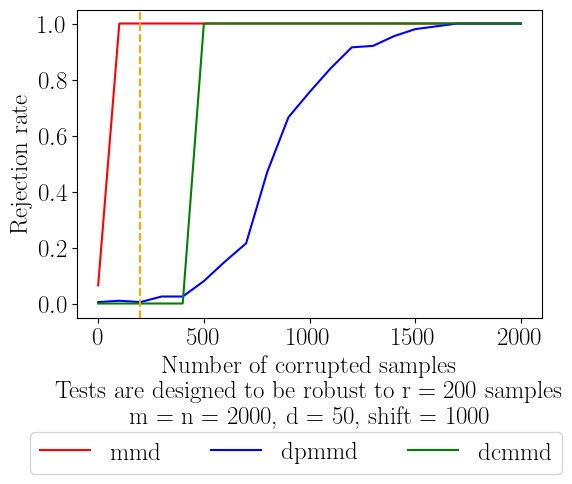

In [74]:
# experiment 
experiment = 1
repetitions = 200
m = n = 2000
d = 50
r = 200

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (mmd, dpmmd, dcmmd)
tests_labels = ('mmd', 'dpmmd', 'dcmmd')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = mmd_sample_synthetic(subkey, m, n, d, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/mmd_synthetic_" + str(experiment) + ".npy", power)
jnp.save("results/mmd_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_mmd()

100%|███████████████████████████████████████████████████████| 200/200 [01:29<00:00,  2.25it/s]

[[0.065      1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [0.005      0.         0.005      0.01       0.005      0.01
  0.015      0.01       0.02       0.04       0.03       0.055
  0.055      0.095      0.105      0.16499999 0.195      0.265
  0.34       0.385      0.42999998]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]]


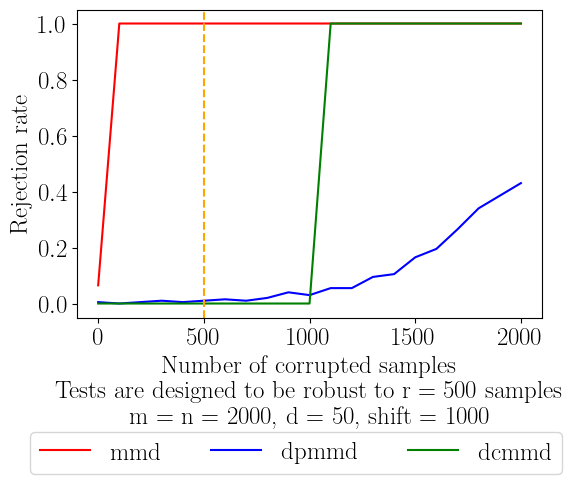

In [75]:
# experiment 
experiment = 2
repetitions = 200
m = n = 2000
d = 50
r = 500

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (mmd, dpmmd, dcmmd)
tests_labels = ('mmd', 'dpmmd', 'dcmmd')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = mmd_sample_synthetic(subkey, m, n, d, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/mmd_synthetic_" + str(experiment) + ".npy", power)
jnp.save("results/mmd_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_mmd()

100%|███████████████████████████████████████████████████████| 200/200 [01:28<00:00,  2.26it/s]

[[0.065 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.005 0.    0.005 0.01  0.    0.01  0.01  0.    0.    0.02  0.01  0.015
  0.01  0.025 0.04  0.015 0.055 0.06  0.04  0.05  0.095]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    1.    1.    1.   ]]


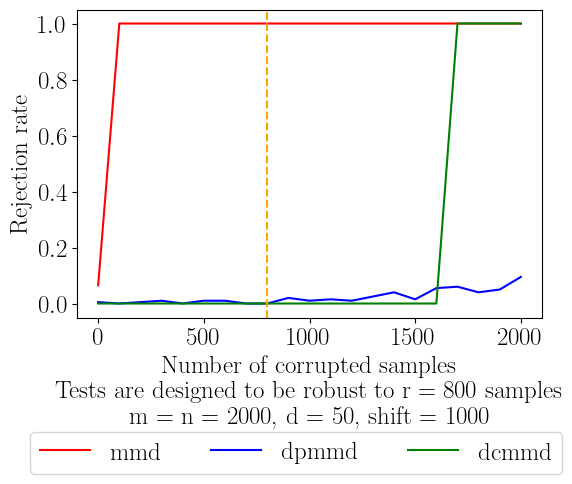

In [76]:
# experiment 
experiment = 3
repetitions = 200
m = n = 2000
d = 50
r = 800

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (mmd, dpmmd, dcmmd)
tests_labels = ('mmd', 'dpmmd', 'dcmmd')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = mmd_sample_synthetic(subkey, m, n, d, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/mmd_synthetic_" + str(experiment) + ".npy", power)
jnp.save("results/mmd_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_mmd()

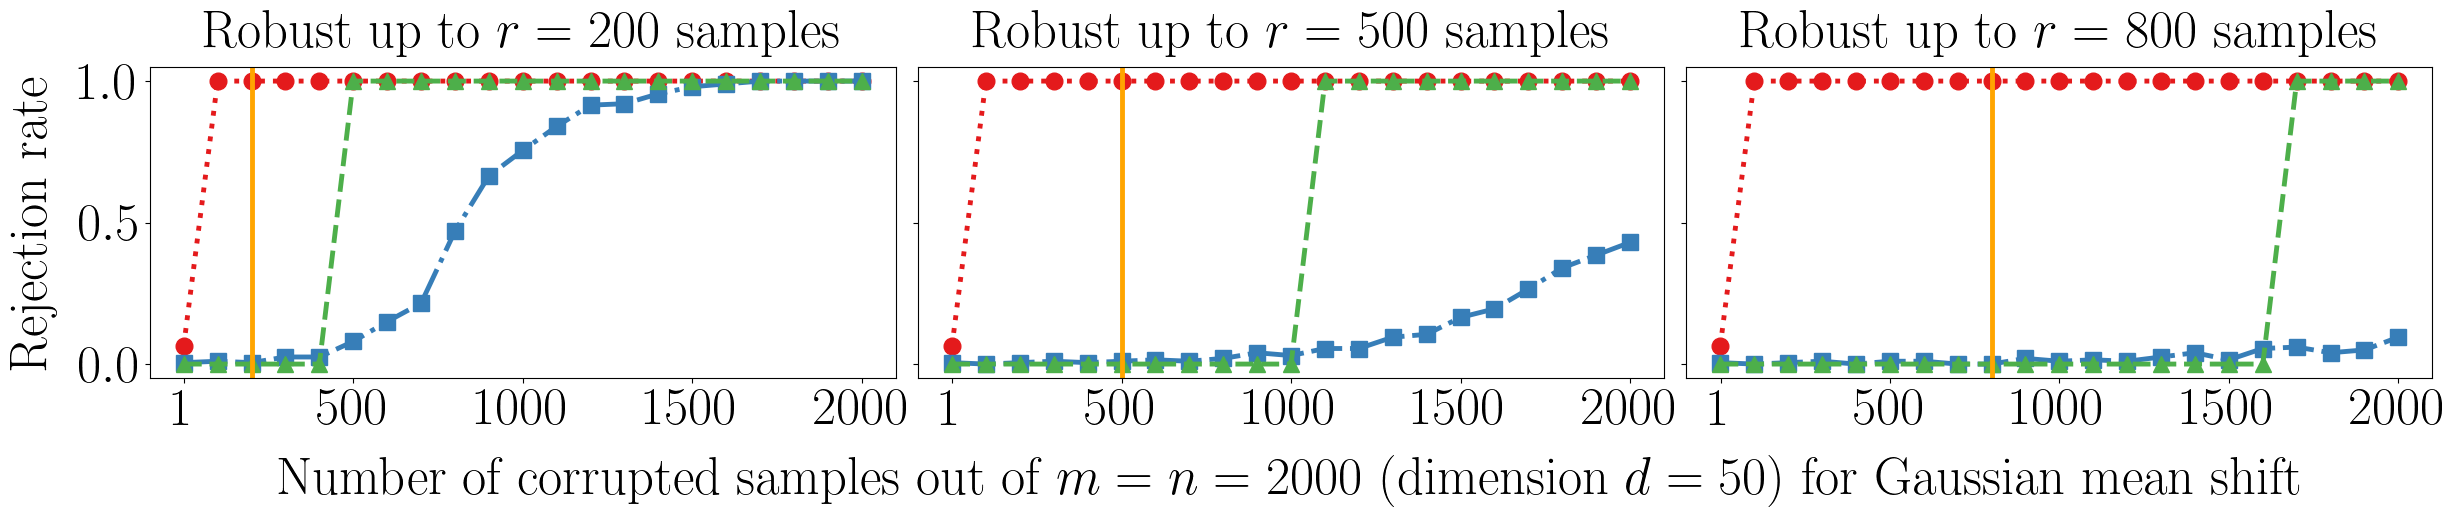

In [388]:
# Figure

# Parameters for plots
fs = 38
rcParams.update({"font.size": fs})
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

# Parameters for plots
linewidth = 3.5
markersize = 12
ylabel_fontsize = 38
xlabel_fontsize = 38
title_fontsize = 38
legend_fontsize = 38
title_pad = 15
xlabel_pad = 15
ylabel_pad = 15

labels = (
    r"\textrm{MMD}",
    r"\textrm{dpMMD}",
    r"\textrm{dcMMD}",
)

# https://gist.github.com/thriveth/8560036
colors = [
    "#e41a1c", # red
    "#377eb8", # blue
    "#4daf4a", # green
]

markers = [
    'o',
    's',
    '^',
]

linestyles = [
    ':',
    '-.',
    '--',
]

# load results
power_1 = np.load("results/mmd_synthetic_1.npy")
x_axis_1 = np.load("results/mmd_synthetic_1_xaxis.npy")

power_2 = np.load("results/mmd_synthetic_2.npy")
x_axis_2 = np.load("results/mmd_synthetic_2_xaxis.npy")

power_3 = np.load("results/mmd_synthetic_3.npy")
x_axis_3 = np.load("results/mmd_synthetic_3_xaxis.npy")

power = (power_1, power_2, power_3)
x_axis = (x_axis_1, x_axis_2, x_axis_3)

ylabel = "Rejection rate"
xlabels = (
    " ",
    r"Number of corrupted samples out of $m=n=2000$ (dimension $d=50$) for Gaussian mean shift",
    "",
)

r_values = (200, 500, 800)

titles = (
    r"Robust up to $r=200$ samples",
    r"Robust up to $r=500$ samples",
    r"Robust up to $r=800$ samples",
)

# create figure
width = 25
height = width / 5
f, axs = plt.subplots(1, 3, figsize=(width, height), sharey=True)
f.tight_layout()
f.subplots_adjust(wspace=0.03, hspace=0.03)
for i in range(3):
    for j in (0, 1, 2):
        axs[i].plot(
                x_axis[i][power[i][j] >= 0],
                power[i][j][power[i][j] >= 0],
                label=labels[j],
                color=colors[j],
                marker=markers[j],
                linestyle=linestyles[j],
                linewidth=linewidth,
                markersize=markersize,
            )
    axs[i].set_title(titles[i], fontsize=title_fontsize, pad=title_pad)
    axs[i].axvline(x=r_values[i], linestyle='-', color='orange', linewidth=linewidth, label=r"$r$")
    axs[i].set_xlabel(xlabels[i], fontsize=xlabel_fontsize, labelpad=xlabel_pad)
    axs[i].set_xticks([1, 500, 1000, 1500, 2000])
axs[0].set_yticks([0, 0.5, 1])
axs[0].set_ylim(-0.05, 1.05)
axs[0].set_ylabel(ylabel, fontsize=ylabel_fontsize, labelpad=ylabel_pad)
handles, labels = axs[1].get_legend_handles_labels()
# sort both labels and handles by labels
#order = (2, 1, 0, 3)
#handles, labels = [handles[idx] for idx in order], [labels[idx] for idx in order]
#axs[1].legend(
#    handles, 
#    labels,
#    fontsize=legend_fontsize,
#    ncol=4,
#    handleheight=0.1,
#    labelspacing=0.5,
#    columnspacing=1.6,
#    handletextpad=0.5,
#    loc="lower center",
#    bbox_to_anchor=(0.5, -0.6),
#)

f.savefig("figures/mmd_synthetic.pdf", dpi=300, bbox_inches="tight")

## Independence synthetic

In [60]:
# plotting function
def plot_hsic():
    # Parameters for plots
    fs = 18
    rcParams.update({"font.size": fs})
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)
    
    labels = ('hsic', 'dphsic', 'dchsic')
    colors = ('red', 'blue', 'green')
    plt.figure(figsize=(6, 4))
    for i in range(len(tests)):
        plt.plot(corruptions, power[i], color=colors[i], label=labels[i])
    plt.axvline(x=r, linestyle='--', color='orange')
    plt.ylabel('Rejection rate')
    plt.xlabel('Number of corrupted samples \n Tests are designed to be robust to r = ' + str(r) + ' samples \n n = ' + str(m) + ', d = ' + str(d) + ', shift = ' + str(shift))
    plt.legend(
        bbox_to_anchor=(1.07, -0.33),
        ncol=3,
    )
    plt.ylim(-0.05, 1.05)


In [49]:
# sampler
def hsic_sample_synthetic(
    key,
    n,
    d,
    c,
):
    subkeys = random.split(key, num=6)
    X = random.normal(subkeys[0], shape=(n, d)) / 10
    Y = random.normal(subkeys[1], shape=(n, d)) / 10
    X = X.at[:int(c/2)].set(
        random.normal(subkeys[2], shape=(int(c/2), d)) / 10 + 1000
    )
    X = X.at[int(c/2):c].set(
        random.normal(subkeys[3], shape=(c - int(c/2), d)) / 10 - 1000
    )
    Y = Y.at[:c].set(
        X[:c] + random.normal(subkeys[4], shape=(c, d)) / 10
    )
    X = random.permutation(subkeys[5], X)
    Y = random.permutation(subkeys[5], Y)
    return X, Y

100%|███████████████████████████████████████████████████████| 200/200 [06:57<00:00,  2.09s/it]

[[0.055      1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.         0.         0.005      0.01       0.015      0.02
  0.035      0.06       0.085      0.105      0.21499999 0.315
  0.35       0.48499998 0.505      0.645      0.695      0.715
  0.78499997 0.84499997 0.895      0.92499995]
 [0.         0.         0.         0.         0.         0.
  0.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]]


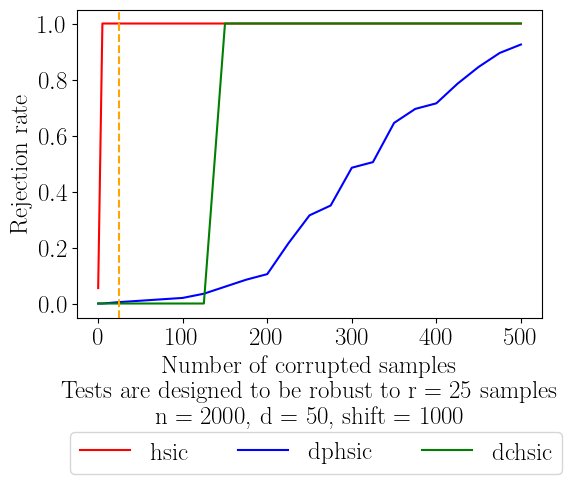

In [65]:
# experiment 
experiment = 1
repetitions = 200
m = n = 2000
d = 50
r = 25

corruptions = [0, 5, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
tests = (hsic, dphsic, dchsic)
tests_labels = ('hsic', 'dphsic', 'dchsic')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = hsic_sample_synthetic(subkey, m, d, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/hsic_synthetic_" + str(experiment) + ".npy", power)
jnp.save("results/hsic_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_hsic()

100%|███████████████████████████████████████████████████████| 200/200 [06:38<00:00,  1.99s/it]

[[0.075      1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [0.005      0.         0.005      0.01       0.005      0.01
  0.015      0.         0.02       0.03       0.02       0.04
  0.015      0.065      0.07       0.075      0.08       0.085
  0.105      0.11499999 0.14      ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         1.         1.         1.         1.
  1.         1.         1.        ]]


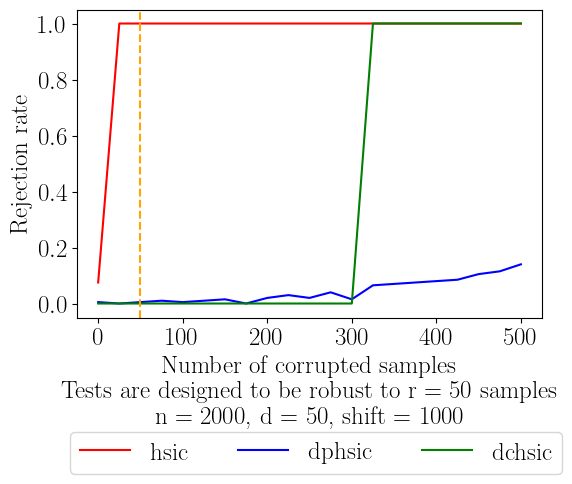

In [52]:
# experiment 
experiment = 2
repetitions = 200
m = n = 2000
d = 50
r = 50

corruptions = [int(i) for i in jnp.linspace(0, 500, 21)]
tests = (hsic, dphsic, dchsic)
tests_labels = ('hsic', 'dphsic', 'dchsic')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = hsic_sample_synthetic(subkey, m, d, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/hsic_synthetic_" + str(experiment) + ".npy", power)
jnp.save("results/hsic_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_hsic()

100%|███████████████████████████████████████████████████████| 200/200 [06:39<00:00,  2.00s/it]

[[0.075 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.005 0.    0.005 0.01  0.005 0.01  0.015 0.    0.02  0.025 0.015 0.03
  0.01  0.035 0.045 0.015 0.055 0.055 0.035 0.04  0.08 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    1.    1.    1.   ]]


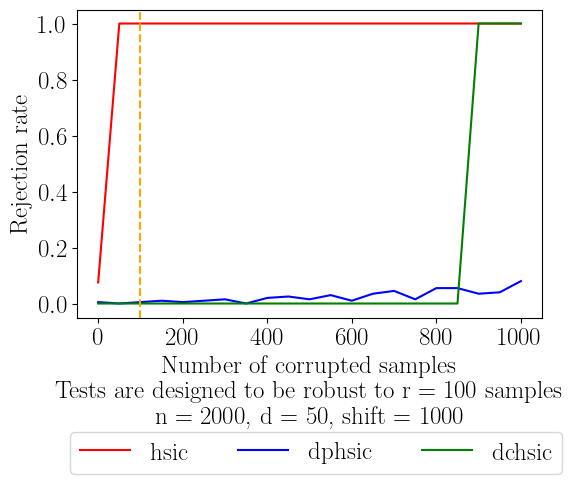

In [53]:
# experiment 
experiment = 3
repetitions = 200
m = n = 2000
d = 50
r = 100

corruptions = [int(i) for i in jnp.linspace(0, 1000, 21)]
tests = (hsic, dphsic, dchsic)
tests_labels = ('hsic', 'dphsic', 'dchsic')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = hsic_sample_synthetic(subkey, m, d, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/hsic_synthetic_" + str(experiment) + ".npy", power)
jnp.save("results/hsic_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_hsic()

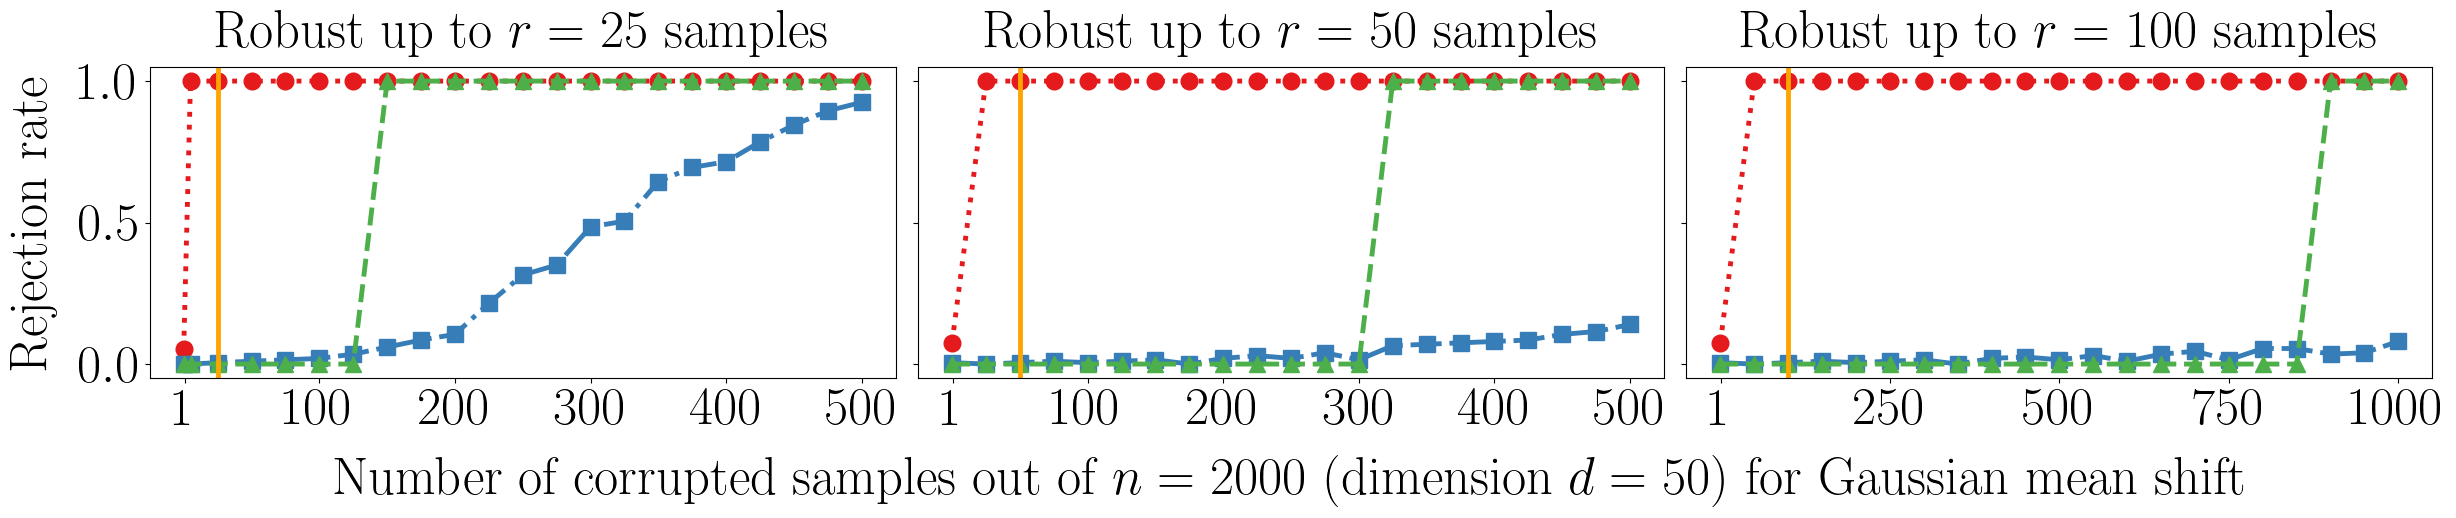

In [379]:
# Figure

# Parameters for plots
fs = 38
rcParams.update({"font.size": fs})
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

# Parameters for plots
linewidth = 3.5
markersize = 12
ylabel_fontsize = 38
xlabel_fontsize = 38
title_fontsize = 38
legend_fontsize = 38
title_pad = 15
xlabel_pad = 15
ylabel_pad = 15

labels = (
    r"\textrm{HSIC}",
    r"\textrm{dpHSIC}",
    r"\textrm{dcHSIC}",
)

# https://gist.github.com/thriveth/8560036
colors = [
    "#e41a1c", # red
    "#377eb8", # blue
    "#4daf4a", # green
]

markers = [
    'o',
    's',
    '^',
]

linestyles = [
    ':',
    '-.',
    '--',
]

# load results
power_1 = np.load("results/hsic_synthetic_1.npy")
x_axis_1 = np.load("results/hsic_synthetic_1_xaxis.npy")

power_2 = np.load("results/hsic_synthetic_2.npy")
x_axis_2 = np.load("results/hsic_synthetic_2_xaxis.npy")

power_3 = np.load("results/hsic_synthetic_3.npy")
x_axis_3 = np.load("results/hsic_synthetic_3_xaxis.npy")

power = (power_1, power_2, power_3)
x_axis = (x_axis_1, x_axis_2, x_axis_3)

ylabel = "Rejection rate"
xlabels = (
    " ",
    r"Number of corrupted samples out of $n=2000$ (dimension $d=50$) for Gaussian mean shift",
    "",
)

r_values = (25, 50, 100)

titles = (
    r"Robust up to $r=25$ samples",
    r"Robust up to $r=50$ samples",
    r"Robust up to $r=100$ samples",
)

# create figure
width = 25
height = width / 5
f, axs = plt.subplots(1, 3, figsize=(width, height), sharey=True)
f.tight_layout()
f.subplots_adjust(wspace=0.03, hspace=0.03)
for i in range(3):
    for j in (0, 1, 2):
        axs[i].plot(
                x_axis[i][power[i][j] >= 0],
                power[i][j][power[i][j] >= 0],
                label=labels[j],
                color=colors[j],
                marker=markers[j],
                linestyle=linestyles[j],
                linewidth=linewidth,
                markersize=markersize,
            )
    axs[i].set_title(titles[i], fontsize=title_fontsize, pad=title_pad)
    axs[i].axvline(x=r_values[i], linestyle='-', color='orange', linewidth=linewidth, label=r"$r$")
    axs[i].set_xlabel(xlabels[i], fontsize=xlabel_fontsize, labelpad=xlabel_pad)
axs[0].set_xticks([1, 100, 200, 300, 400, 500])
axs[1].set_xticks([1, 100, 200, 300, 400, 500])
axs[2].set_xticks([1, 250, 500, 750, 1000])
axs[0].set_yticks([0, 0.5, 1])
axs[0].set_ylim(-0.05, 1.05)
axs[0].set_ylabel(ylabel, fontsize=ylabel_fontsize, labelpad=ylabel_pad)
handles, labels = axs[1].get_legend_handles_labels()
# sort both labels and handles by labels
#order = (2, 1, 0, 3)
#handles, labels = [handles[idx] for idx in order], [labels[idx] for idx in order]
#axs[1].legend(
#    handles, 
#    labels,
#    fontsize=legend_fontsize,
#    ncol=4,
#    handleheight=0.1,
#    labelspacing=0.5,
#    columnspacing=1.6,
#    handletextpad=0.5,
#    loc="lower center",
#    bbox_to_anchor=(0.5, -0.6),
#)

f.savefig("figures/hsic_synthetic.pdf", dpi=300, bbox_inches="tight")

# imdb

In [ ]:
def load_imdb():
    # load data
    data, labels = load_svmlight_file('imdb/features_libsvm.txt')
    sentiment = np.loadtxt('imdb/sentiment.txt')
    
    # keep only features with extreme sentiment values
    threshold = 2.5 
    selected_col_indices = list(compress(range(len(sentiment > threshold)), sentiment > threshold))
    selected_col_indices = selected_col_indices + list(compress(range(len(sentiment < -threshold)), sentiment < -threshold))
    cols = []
    for i in selected_col_indices:
        cols.append(data[:, i])
    data = scipy.sparse.hstack(cols).toarray()
    
    # keep only non-zero rows for positive feedback
    data_pos = data[:int(25000 / 2)]
    selected_row_indices = list(compress(range(len(np.sum(data_pos, 1) > 0)), np.sum(data_pos, 1) > 0)) 
    rows = []
    for i in selected_row_indices:
        rows.append(data_pos[i, :])
    data_pos = np.vstack(rows)
    
    # keep only non-zero rows for negative feedback
    data_neg = data[int(25000 / 2):]
    selected_row_indices = list(compress(range(len(np.sum(data_neg, 1) > 0)), np.sum(data_neg, 1) > 0)) 
    rows = []
    for i in selected_row_indices:
        rows.append(data_neg[i, :])
    data_neg = np.vstack(rows)
    
    return data_pos, data_neg

data_pos, data_neg = load_imdb()


## imdb two-sample

In [360]:
# plotting function
def plot_mmd_imdb():
    # Parameters for plots
    fs = 18
    rcParams.update({"font.size": fs})
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)

    # Plot
    labels = ('mmd', 'dpmmd', 'dcmmd')
    colors = ('red', 'blue', 'green')
    plt.figure(figsize=(6, 4))
    for i in range(len(tests)):
        plt.plot(corruptions, power[i], color=colors[i], label=labels[i])
    plt.axvline(x=r, linestyle='--', color='orange')
    plt.ylabel('Rejection rate')
    plt.xlabel('Number of corrupted samples \n Tests are designed to be robust to r = ' + str(r) + ' samples \n m = n = ' + str(m))
    plt.legend(
        bbox_to_anchor=(1.07, -0.33),
        ncol=3,
    )
    plt.ylim(-0.05, 1.05)

In [286]:
# sampler
def mmd_sample_imdb(
    key,
    m,
    n,
    c,
):
    assert max(n, m) <= data_pos.shape[0] / 2
    data_pos_1 = data_pos[:int(data_pos.shape[0] / 2)]
    data_pos_2 = data_pos[int(data_pos.shape[0] / 2):]
    subkeys = random.split(key, num=4)
    X = random.permutation(subkeys[0], data_pos_1)[:m]
    Y = random.permutation(subkeys[1], data_pos_2)[:n]
    Y = Y.at[:c].set(
        random.geometric(subkey, p=0.05, shape=(c, data_pos.shape[1])) - 1
    )
    return X, Y

100%|███████████████████████████████████████████████████████| 200/200 [16:08<00:00,  4.84s/it]


[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [0.005      0.         0.005      0.015      0.005      0.035
  0.04       0.03       0.125      0.19       0.275      0.355
  0.515      0.64       0.695      0.78999996 0.865      0.935
  0.955      0.945      0.965     ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]]


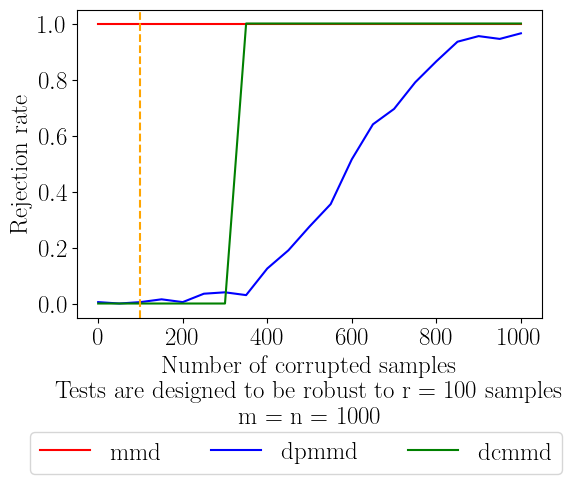

In [356]:
# experiment 
experiment = 1
repetitions = 200
m = n = 1000
r = 100

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (mmd, dpmmd, dcmmd)
tests_labels = ('mmd', 'dpmmd', 'dcmmd')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = mmd_sample_imdb(subkey, m, n, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/mmd_imdb_" + str(experiment) + ".npy", power)
jnp.save("results/mmd_imdb_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_mmd_imdb()

100%|███████████████████████████████████████████████████████| 200/200 [16:07<00:00,  4.84s/it]


[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [0.005      0.         0.005      0.01       0.005      0.01
  0.015      0.         0.02       0.025      0.015      0.04
  0.025      0.07       0.08       0.085      0.09999999 0.14999999
  0.185      0.21499999 0.25      ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         1.         1.         1.         1.
  1.         1.         1.        ]]


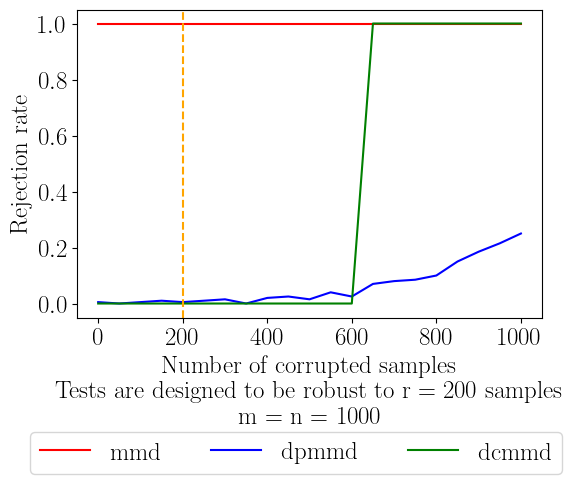

In [357]:
# experiment 
experiment = 2
repetitions = 200
m = n = 1000
r = 200

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (mmd, dpmmd, dcmmd)
tests_labels = ('mmd', 'dpmmd', 'dcmmd')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = mmd_sample_imdb(subkey, m, n, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/mmd_imdb_" + str(experiment) + ".npy", power)
jnp.save("results/mmd_imdb_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_mmd_imdb()

100%|███████████████████████████████████████████████████████| 200/200 [16:15<00:00,  4.88s/it]


[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.005 0.    0.    0.01  0.    0.01  0.01  0.    0.    0.02  0.01  0.005
  0.    0.015 0.03  0.015 0.055 0.045 0.035 0.04  0.085]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.02  1.    1.   ]]


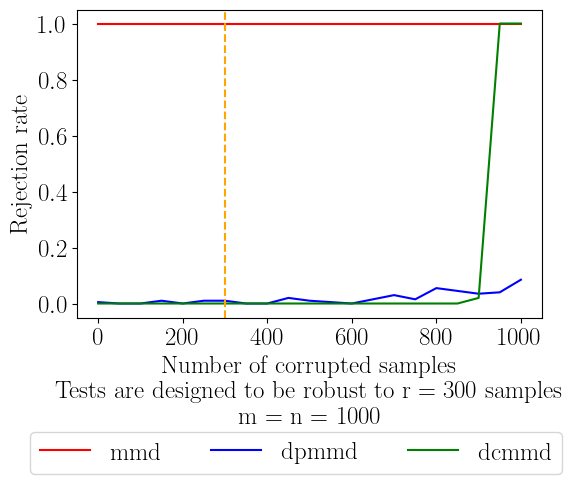

In [358]:
# experiment 
experiment = 3
repetitions = 200
m = n = 1000
r = 300

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (mmd, dpmmd, dcmmd)
tests_labels = ('mmd', 'dpmmd', 'dcmmd')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = mmd_sample_imdb(subkey, m, n, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/mmd_imdb_" + str(experiment) + ".npy", power)
jnp.save("results/mmd_imdb_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_mmd_imdb()

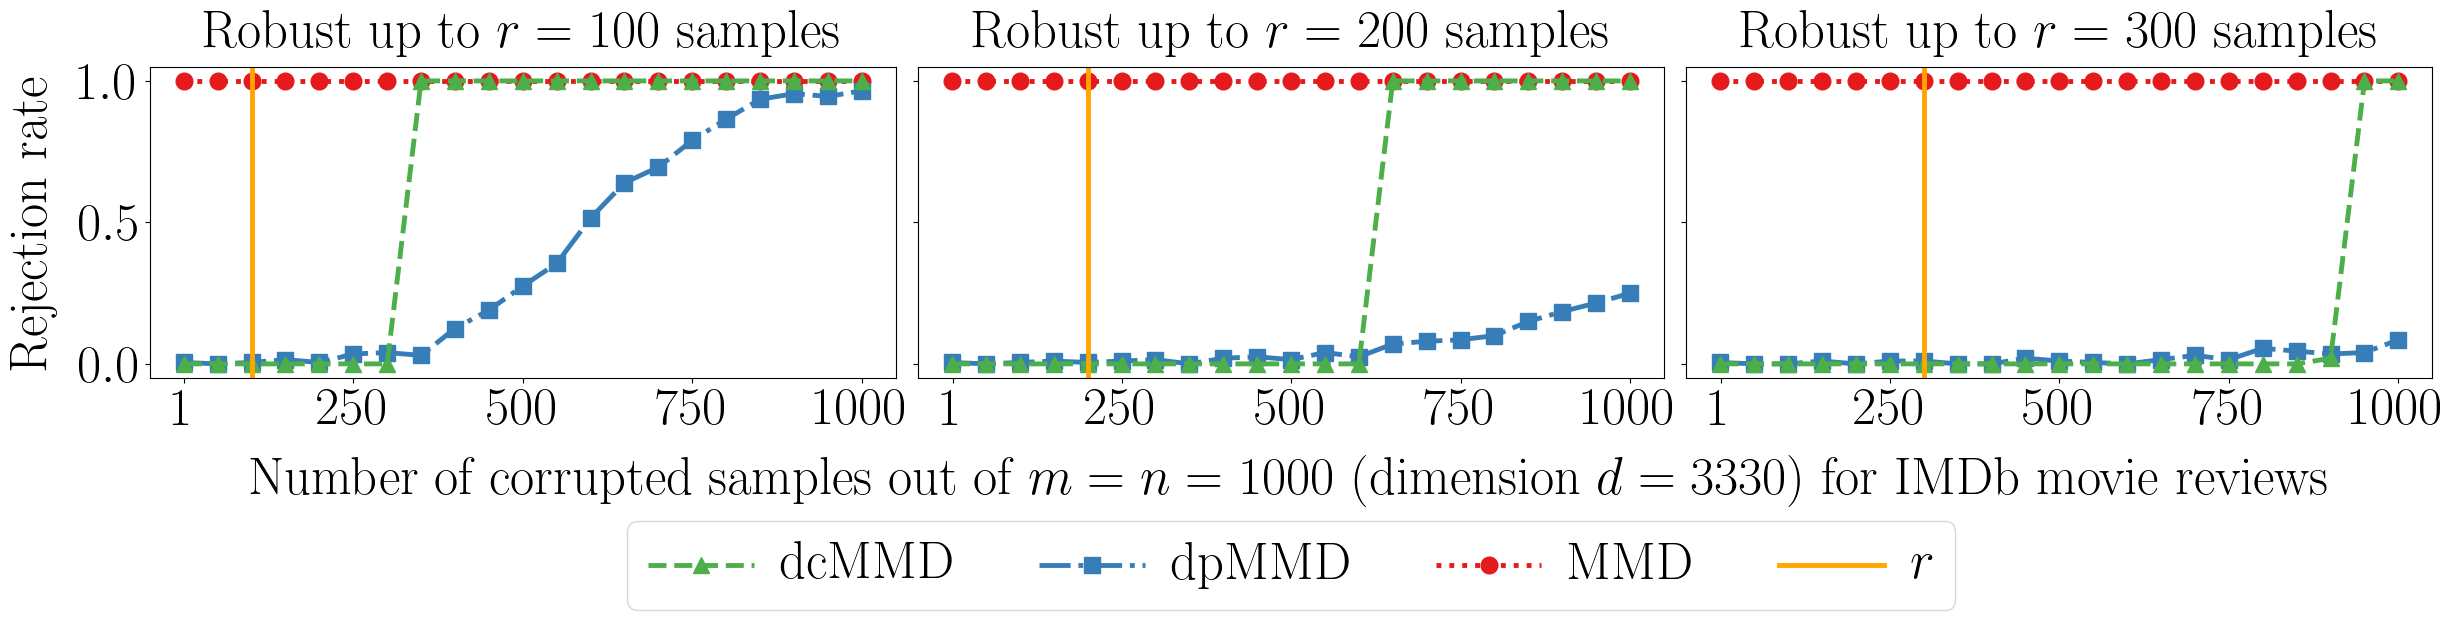

In [389]:
# Figure

# Parameters for plots
fs = 38
rcParams.update({"font.size": fs})
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

# Parameters for plots
linewidth = 3.5
markersize = 12
ylabel_fontsize = 38
xlabel_fontsize = 38
title_fontsize = 38
legend_fontsize = 38
title_pad = 15
xlabel_pad = 15
ylabel_pad = 15

labels = (
    r"\textrm{MMD}",
    r"\textrm{dpMMD}",
    r"\textrm{dcMMD}",
)

# https://gist.github.com/thriveth/8560036
colors = [
    "#e41a1c", # red
    "#377eb8", # blue
    "#4daf4a", # green
]

markers = [
    'o',
    's',
    '^',
]

linestyles = [
    ':',
    '-.',
    '--',
]

# load results
power_1 = np.load("results/mmd_imdb_1.npy")
x_axis_1 = np.load("results/mmd_imdb_1_xaxis.npy")

power_2 = np.load("results/mmd_imdb_2.npy")
x_axis_2 = np.load("results/mmd_imdb_2_xaxis.npy")

power_3 = np.load("results/mmd_imdb_3.npy")
x_axis_3 = np.load("results/mmd_imdb_3_xaxis.npy")

power = (power_1, power_2, power_3)
x_axis = (x_axis_1, x_axis_2, x_axis_3)

ylabel = "Rejection rate"
xlabels = (
    " ",
    r"Number of corrupted samples out of $m=n=1000$ (dimension $d=3330$) for IMDb movie reviews",
    "",
)

r_values = (100, 200, 300)

titles = (
    r"Robust up to $r=100$ samples",
    r"Robust up to $r=200$ samples",
    r"Robust up to $r=300$ samples",
)

# create figure
width = 25
height = width / 5
f, axs = plt.subplots(1, 3, figsize=(width, height), sharey=True)
f.tight_layout()
f.subplots_adjust(wspace=0.03, hspace=0.03)
for i in range(3):
    for j in (0, 1, 2):
        axs[i].plot(
                x_axis[i][power[i][j] >= 0],
                power[i][j][power[i][j] >= 0],
                label=labels[j],
                color=colors[j],
                marker=markers[j],
                linestyle=linestyles[j],
                linewidth=linewidth,
                markersize=markersize,
            )
    axs[i].set_title(titles[i], fontsize=title_fontsize, pad=title_pad)
    axs[i].axvline(x=r_values[i], linestyle='-', color='orange', linewidth=linewidth, label=r"$r$")
    axs[i].set_xlabel(xlabels[i], fontsize=xlabel_fontsize, labelpad=xlabel_pad)
    axs[i].set_xticks([1, 250, 500, 750, 1000])
axs[0].set_yticks([0, 0.5, 1])
axs[0].set_ylim(-0.05, 1.05)
axs[0].set_ylabel(ylabel, fontsize=ylabel_fontsize, labelpad=ylabel_pad)
handles, labels = axs[1].get_legend_handles_labels()
# sort both labels and handles by labels
order = (2, 1, 0, 3)
handles, labels = [handles[idx] for idx in order], [labels[idx] for idx in order]
axs[1].legend(
    handles, 
    labels,
    fontsize=legend_fontsize,
    ncol=4,
    handleheight=0.1,
    labelspacing=0.5,
    columnspacing=1.6,
    handletextpad=0.5,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.83),
)

f.savefig("figures/mmd_imdb.pdf", dpi=300, bbox_inches="tight")

## imdb independence

In [350]:
# plotting function
def plot_hsic_imdb():
    # Parameters for plots
    fs = 18
    rcParams.update({"font.size": fs})
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)
    
    labels = ('hsic', 'dphsic', 'dchsic')
    colors = ('red', 'blue', 'green')
    plt.figure(figsize=(6, 4))
    for i in range(len(tests)):
        plt.plot(corruptions, power[i], color=colors[i], label=labels[i])
    plt.axvline(x=r, linestyle='--', color='orange')
    plt.ylabel('Rejection rate')
    plt.xlabel('Number of corrupted samples \n Tests are designed to be robust to r = ' + str(r) + ' samples \n n = ' + str(m))
    plt.legend(
        bbox_to_anchor=(1.07, -0.33),
        ncol=3,
    )
    plt.ylim(-0.05, 1.05)


In [351]:
# sampler
def hsic_sample_imdb(
    key,
    n,
    c,
):
    assert n <= data_pos.shape[0]
    assert n <= data_neg.shape[0]
    subkeys = random.split(key, num=6)
    X = random.permutation(subkeys[0], data_pos)[:n]
    Y = random.permutation(subkeys[1], data_neg)[:n]
    X = X.at[:int(c/2)].set(
        random.geometric(subkeys[2], p=0.05, shape=(int(c/2), data_pos.shape[1])) - 1
    )
    X = X.at[int(c/2):c].set(
        (random.geometric(subkeys[3], p=0.05, shape=(c - int(c/2), data_pos.shape[1])) - 1) + 5
    )
    Y = Y.at[:c].set(
        X[:c] + random.normal(subkeys[4], shape=(c, data_pos.shape[1])) / 10
    )
    X = random.permutation(subkeys[5], X)
    Y = random.permutation(subkeys[5], Y)
    return X, Y

100%|█████████████████████████████████████████████████████| 200/200 [1:27:22<00:00, 26.21s/it]

[[0.045      1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.         0.         0.005      0.01       0.02       0.035
  0.05       0.095      0.12       0.28       0.42499998 0.51
  0.59999996 0.685      0.74       0.87       0.805      0.885
  0.875      0.91999996 0.955      0.965     ]
 [0.         0.         0.         0.         0.         0.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]]


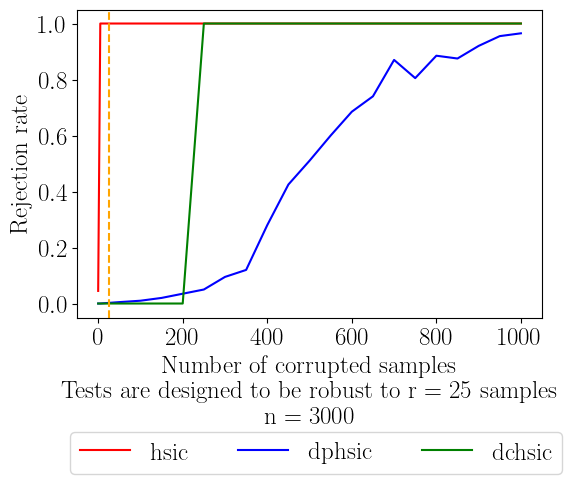

In [352]:
# experiment
experiment = 1
repetitions = 200
m = n = 3000
r = 25

corruptions = [0, 5] + [int(i) for i in jnp.linspace(0, 1000, 21)][1:]
tests = (hsic, dphsic, dchsic)
tests_labels = ('hsic', 'dphsic', 'dchsic')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = hsic_sample_imdb(subkey, n, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/hsic_imdb_" + str(experiment) + ".npy", power)
jnp.save("results/hsic_imdb_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_hsic_imdb()

100%|█████████████████████████████████████████████████████| 200/200 [1:27:22<00:00, 26.21s/it]

[[0.045      1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.         0.         0.005      0.01       0.005      0.015
  0.01       0.015      0.035      0.02       0.035      0.045
  0.055      0.08       0.06       0.09999999 0.085      0.14
  0.13499999 0.22999999 0.17       0.21      ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]]


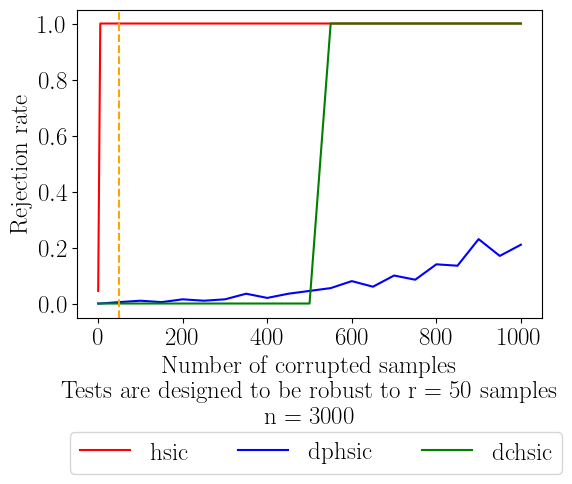

In [353]:
# experiment
experiment = 2
repetitions = 200
m = n = 3000
r = 50

corruptions = [0, 5] + [int(i) for i in jnp.linspace(0, 1000, 21)][1:]
tests = (hsic, dphsic, dchsic)
tests_labels = ('hsic', 'dphsic', 'dchsic')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = hsic_sample_imdb(subkey, n, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/hsic_imdb_" + str(experiment) + ".npy", power)
jnp.save("results/hsic_imdb_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_hsic_imdb()

100%|█████████████████████████████████████████████████████| 200/200 [1:27:22<00:00, 26.21s/it]

[[0.045 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.    0.    0.005 0.005 0.    0.01  0.005 0.01  0.025 0.    0.025 0.
  0.01  0.04  0.02  0.04  0.02  0.03  0.03  0.06  0.045 0.07 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    1.    1.   ]]


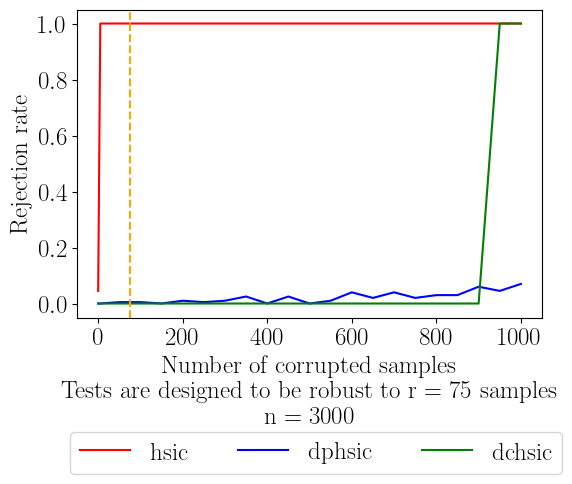

In [354]:
# experiment
experiment = 3
repetitions = 200
m = n = 3000
r = 75

corruptions = [0, 5] + [int(i) for i in jnp.linspace(0, 1000, 21)][1:]
tests = (hsic, dphsic, dchsic)
tests_labels = ('hsic', 'dphsic', 'dchsic')

# run experiment
key = random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = random.split(key)
        X, Y = hsic_sample_imdb(subkey, n, c)
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                )
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/hsic_imdb_" + str(experiment) + ".npy", power)
jnp.save("results/hsic_imdb_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)
plot_hsic_imdb()

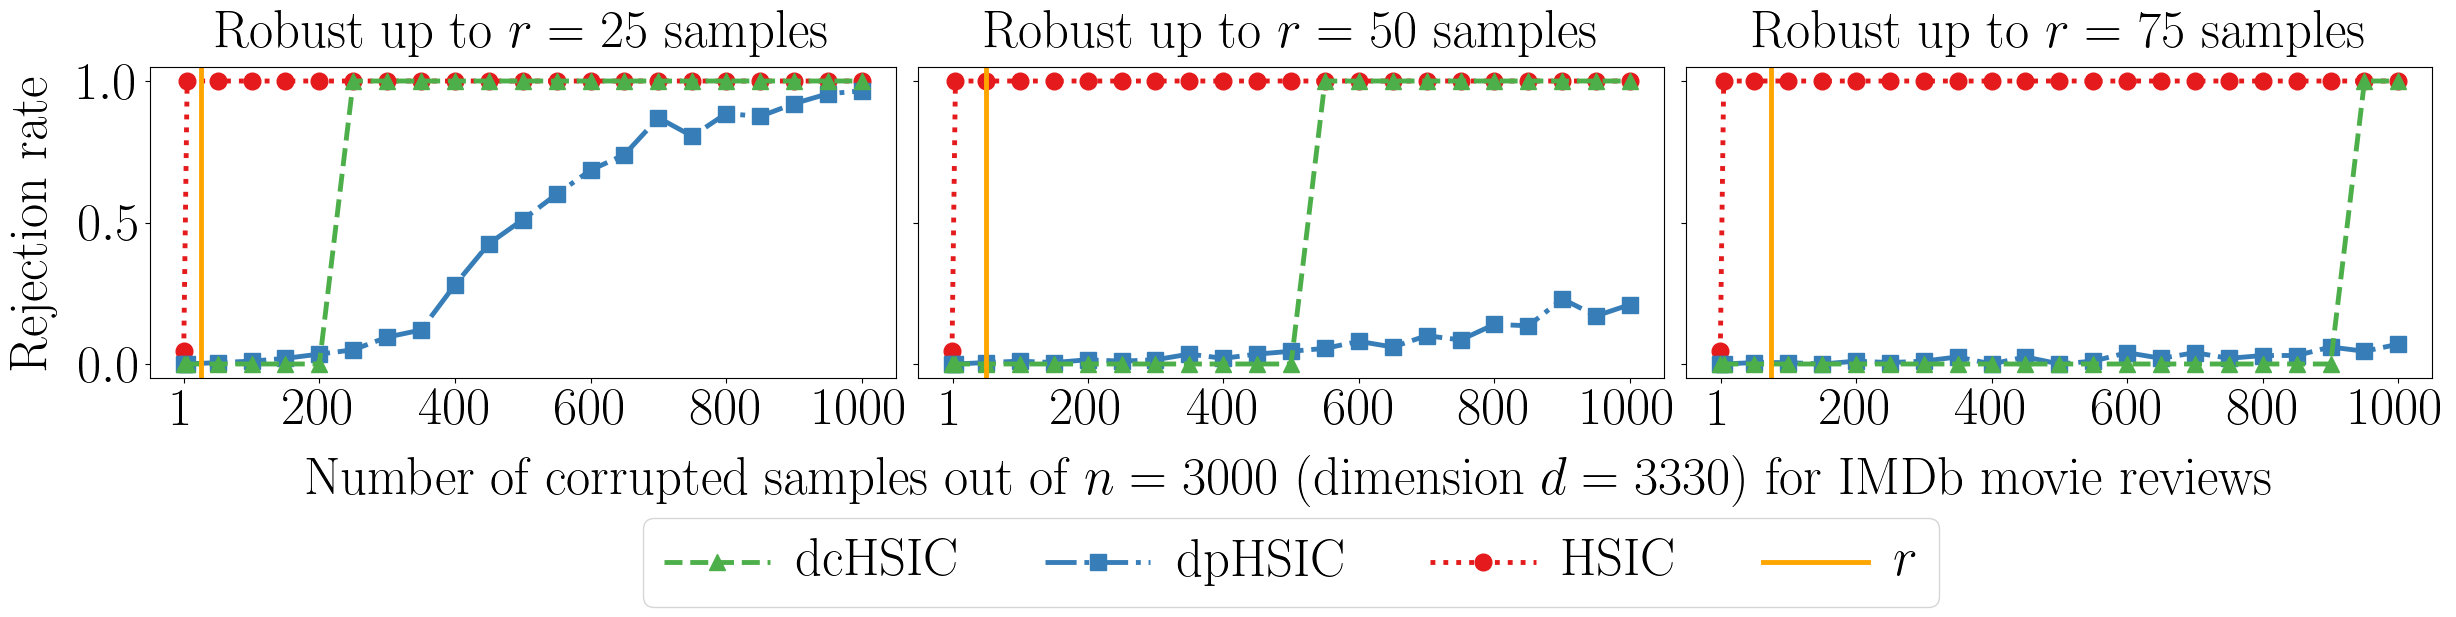

In [390]:
# Figure

# Parameters for plots
fs = 38
rcParams.update({"font.size": fs})
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

# Parameters for plots
linewidth = 3.5
markersize = 12
ylabel_fontsize = 38
xlabel_fontsize = 38
title_fontsize = 38
legend_fontsize = 38
title_pad = 15
xlabel_pad = 15
ylabel_pad = 15

labels = (
    r"\textrm{HSIC}",
    r"\textrm{dpHSIC}",
    r"\textrm{dcHSIC}",
)

# https://gist.github.com/thriveth/8560036
colors = [
    "#e41a1c", # red
    "#377eb8", # blue
    "#4daf4a", # green
]

markers = [
    'o',
    's',
    '^',
]

linestyles = [
    ':',
    '-.',
    '--',
]

# load results
power_1 = np.load("results/hsic_imdb_1.npy")
x_axis_1 = np.load("results/hsic_imdb_1_xaxis.npy")

power_2 = np.load("results/hsic_imdb_2.npy")
x_axis_2 = np.load("results/hsic_imdb_2_xaxis.npy")

power_3 = np.load("results/hsic_imdb_3.npy")
x_axis_3 = np.load("results/hsic_imdb_3_xaxis.npy")

power = (power_1, power_2, power_3)
x_axis = (x_axis_1, x_axis_2, x_axis_3)

ylabel = "Rejection rate"
xlabels = (
    " ",
    r"Number of corrupted samples out of $n=3000$ (dimension $d=3330$) for IMDb movie reviews",
    "",
)

r_values = (25, 50, 75)

titles = (
    r"Robust up to $r=25$ samples",
    r"Robust up to $r=50$ samples",
    r"Robust up to $r=75$ samples",
)

# create figure
width = 25
height = width / 5
f, axs = plt.subplots(1, 3, figsize=(width, height), sharey=True)
f.tight_layout()
f.subplots_adjust(wspace=0.03, hspace=0.03)
for i in range(3):
    for j in (0, 1, 2):
        axs[i].plot(
                x_axis[i][power[i][j] >= 0],
                power[i][j][power[i][j] >= 0],
                label=labels[j],
                color=colors[j],
                marker=markers[j],
                linestyle=linestyles[j],
                linewidth=linewidth,
                markersize=markersize,
            )
    axs[i].set_title(titles[i], fontsize=title_fontsize, pad=title_pad)
    axs[i].axvline(x=r_values[i], linestyle='-', color='orange', linewidth=linewidth, label=r"$r$")
    axs[i].set_xlabel(xlabels[i], fontsize=xlabel_fontsize, labelpad=xlabel_pad)
axs[0].set_xticks([1, 200, 400, 600, 800, 1000])
axs[1].set_xticks([1, 200, 400, 600, 800, 1000])
axs[2].set_xticks([1, 200, 400, 600, 800, 1000])
axs[0].set_yticks([0, 0.5, 1])
axs[0].set_ylim(-0.05, 1.05)
axs[0].set_ylabel(ylabel, fontsize=ylabel_fontsize, labelpad=ylabel_pad)
handles, labels = axs[1].get_legend_handles_labels()
# sort both labels and handles by labels
order = (2, 1, 0, 3)
handles, labels = [handles[idx] for idx in order], [labels[idx] for idx in order]
axs[1].legend(
    handles, 
    labels,
    fontsize=legend_fontsize,
    ncol=4,
    handleheight=0.1,
    labelspacing=0.5,
    columnspacing=1.6,
    handletextpad=0.5,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.82),
)

f.savefig("figures/hsic_imdb.pdf", dpi=300, bbox_inches="tight")